In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential

In [12]:
df=pd.read_csv("/content/MarketPricePrediction.csv",parse_dates=['date'])

In [13]:
import warnings
warnings.filterwarnings("ignore")
markets=df['market'].unique()
cols=["market","date","quantity","priceMin","priceMax","priceMod"]
df_list=[]
for i in markets:
    filtered_df=df[df["market"]==i]
    filtered_df=filtered_df[cols]
    min_date=filtered_df['date'].min()
    max_date=filtered_df['date'].max()
    date_range=pd.date_range(start=min_date,end=max_date,freq="MS")
    filtered_df.set_index("date",drop=True,inplace=True)
    missing_date=date_range[~date_range.isin(filtered_df.index)]
    date_reindexed=filtered_df.reindex(date_range)
    data=date_reindexed.interpolate(method="linear")
    data['market']=data['market'].fillna(data['market'].mode())
    df_list.append(data)
cleaned_df=pd.concat(df_list,axis=0)
cleaned_df['market'].fillna(method="ffill",inplace=True)

In [14]:
cleaned_df

,market,quantity,priceMin,priceMax,priceMod
2005-01-01,ABOHAR(PB),2350.0,404.0,493.0,446.0
2005-02-01,ABOHAR(PB),1400.0,286.0,365.0,324.0
2005-03-01,ABOHAR(PB),900.0,281.0,357.0,322.0
2005-04-01,ABOHAR(PB),637.5,335.5,453.5,398.5
2005-05-01,ABOHAR(PB),375.0,390.0,550.0,475.0
...,...,...,...,...,...
2015-10-01,YEOLA(MS),15593.0,1046.0,3537.0,2886.0
2015-11-01,YEOLA(MS),62522.0,1003.0,2460.0,1996.0
2015-12-01,YEOLA(MS),223315.0,609.0,1446.0,1126.0
2016-01-01,YEOLA(MS),437432.0,437.0,1272.0,1034.0


In [18]:
final_df=cleaned_df[cleaned_df["market"]=="ABOHAR(PB)"][['priceMod']]

In [21]:
final_df.head()

,priceMod
2005-01-01,446.0
2005-02-01,324.0
2005-03-01,322.0
2005-04-01,398.5
2005-05-01,475.0


In [24]:
train = final_df.iloc[:100]
test = final_df.iloc[100:]

In [25]:
#Lets normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(train)
scaled_test = scaler.transform(test)


In [126]:
generator = TimeseriesGenerator(scaled_train,scaled_train,length=12,batch_size=32)

In [136]:
model=Sequential()
model.add(LSTM(units=200,kernel_initializer="he_normal",input_shape=(12,1)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(Dense(1))

In [137]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer='adam',loss='mse',metrics=MeanSquaredError())

In [138]:
model.fit(generator,epochs=100)

Epoch 1/100
3/3 [==============================] - 2s 25ms/step - loss: 0.1056 - mean_squared_error: 0.1112
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0461 - mean_squared_error: 0.0507
Epoch 3/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0436 - mean_squared_error: 0.0418
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0312 - mean_squared_error: 0.0298
Epoch 5/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0335 - mean_squared_error: 0.0316
Epoch 6/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0257 - mean_squared_error: 0.0250
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0156 - mean_squared_error: 0.0150
Epoch 8/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0191 - mean_squared_error: 0.0186
Epoch 9/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0153 - mean_squared_error: 0.0147
Epoch 10/100
3/3 [==========

In [148]:
# For predicting the first value of test data, we need the last 12 values of train data
# given that the data is sequential
last_train = scaled_train[-12:]
last_train

array([[0.06383658],
       [0.08203   ],
       [0.12543888],
       [0.15512289],
       [0.15161187],
       [0.19948931],
       [0.27130546],
       [0.30960741],
       [0.41653367],
       [0.42419406],
       [0.24896266],
       [0.23459943]])

In [149]:
last_train = last_train.reshape((1,12,1))
scaler.inverse_transform(model.predict(last_train))

1/1 [==============================] - 0s 23ms/step


array([[1173.1287]], dtype=float32)

In [150]:
scaler.inverse_transform(scaled_test[0].reshape(-1,1))

array([[814.]])

In [151]:
scaled_final=scaler.transform(final_df)
full_data_generator=TimeseriesGenerator(scaled_final,scaled_final,length=12,batch_size=1)

In [152]:
full_data_preds=model.predict(full_data_generator)

115/115 [==============================] - 0s 4ms/step


In [158]:
full_data_preds.shape,final_df.shape[0]-12

((115, 1), 115)

In [153]:
predicted_data=scaler.inverse_transform(full_data_preds)

In [159]:
result_df=pd.DataFrame(list(zip(predicted_data.reshape(-1),final_df[12:].values.reshape(-1))),
                       index=final_df.index[12:],
                       columns=["Predicted","Actual"])

<Axes: >

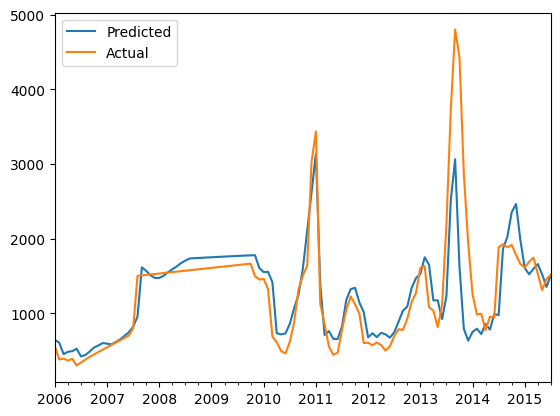

In [160]:
result_df.plot()

(array([[[0.0466007 ],
         [0.00766039],
         [0.00702202],
         [0.03143951],
         [0.05585701],
         [0.00574529],
         [0.01532078],
         [0.0635174 ],
         [0.21161826],
         [0.29269071],
         [0.12767316],
         [0.09639323]]]),
 array([[0.0839451]]))

In [120]:
scaled_final[12]

array([0.0839451])